In [33]:
import wandb
import os

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from palettable.cartocolors.qualitative import *

sns.set(style='white', font_scale=1.75)
# despine by default
plt.rc("axes.spines", top=False, right=False)
# avoid Type 3 fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [34]:
sweep_id = "8dr79fiv"
local_fpath = f"./lambo_results_{sweep_id}.csv"
overwrite = False

if os.path.exists(local_fpath) and not overwrite:
    full_df = pd.read_csv(local_fpath)
else:
    api = wandb.Api()
    sweep = api.sweep(f"samuelstanton/lambo/{sweep_id}")
    df_list = []
    for run in sweep.runs:


        history = run.scan_history()
        df = pd.DataFrame(history)
        
        df.loc[:, "random_seed"] = run.config["seed"]
        df.loc[:, "design_seed_temp"] = run.config["optimizer.resampling_weight"] 
        df_list.append(df)
    full_df = pd.concat(df_list, ignore_index=True)
    
    full_df.to_csv(local_fpath, index=None)

## drop unneeded rows

In [35]:
obj_col = "chem_lsbo/candidates/obj_val_0"
df = full_df.dropna(subset=[obj_col])
df = df[df.design_seed_temp == 0.5]

## get best candidate from each batch per round

In [36]:
x_col = "chem_lsbo/candidates/round_idx"
seed_col ="random_seed"

df = df.groupby([seed_col, x_col])[obj_col].min().sort_index().reset_index()

## cummin and negate

In [37]:
df["obj_cummax"] = -1.0 * df.groupby(seed_col)[obj_col].cummin().values

In [38]:
median = df.groupby(x_col)["obj_cummax"].quantile(0.6)
lb = df.groupby(x_col)["obj_cummax"].quantile(0.4)
ub = df.groupby(x_col)["obj_cummax"].quantile(0.8)

x_vals = np.arange(len(median)) * 50

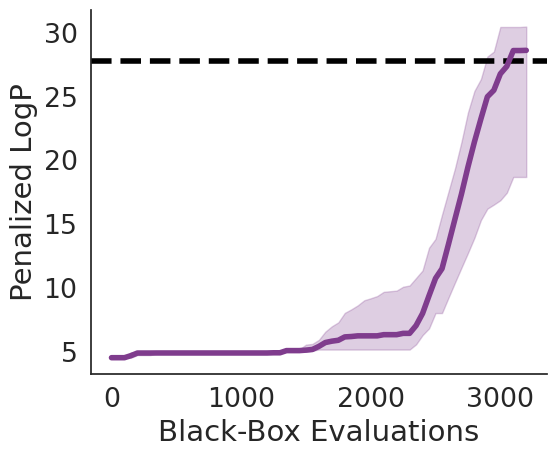

In [39]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(x_vals, median, color=Bold_7.hex_colors[0], linewidth=4)
ax.fill_between(x_vals, lb, ub, alpha=0.25, color=Bold_7.hex_colors[0])

xlim = ax.get_xlim()
ax.set_xlim(xlim)
lsbo_perf = 27.8
ax.hlines(lsbo_perf, *xlim, color="black", linestyle="--", linewidth=4)

ax.set_ylabel("Penalized LogP")
ax.set_xlabel("Black-Box Evaluations")
plt.tight_layout()

In [40]:
df.random_seed.unique()

array([0, 1, 2, 3, 4])

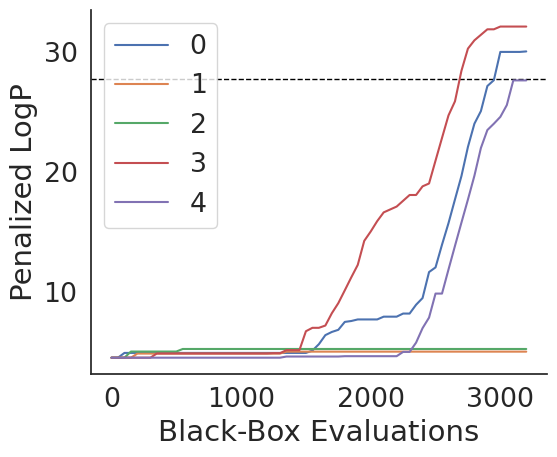

In [42]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1, 1, 1)

for seed in df.random_seed.unique():
    select_df = df[df.random_seed == seed]
    ax.plot(x_vals, select_df.obj_cummax, label=seed)
    
xlim = ax.get_xlim()
ax.set_xlim(xlim)
lsbo_perf = 27.8
ax.hlines(lsbo_perf, *xlim, color="black", linestyle="--", linewidth=1)

ax.set_ylabel("Penalized LogP")
ax.set_xlabel("Black-Box Evaluations")
plt.legend()
plt.tight_layout()